# Lab Practice: Online Learning
**Interuniversity Master’s Degree in Artificial Intelligence**  
**Course:** Machine Learing II (MLII)  
**Academic Year:** 2025–2026  

---

## Group Members
- Cristian Marquina
- Francisco Vázquez
- Jose Carlos Bordón Maldonado
- Daniel González
- Gian Paolo 

---

## Problem Description
The goal of this project is to predict the future price of a financial asset (specifically, the "High" price of the SPY ETF five days into the future). By forecasting these values, we aim to provide a tool that helps in anticipating market trends and making informed investment decisions.

Machine Learning Viewpoint:
* Problem Type: This is a regression problem, as the target variable ($Target\_High$) is a continuous numerical value representing a stock price.
* Imbalance: While not a classification problem (where class imbalance is typical), we must monitor for volatility spikes or extreme outliers in stock prices that could bias the model.
* Influence of Drift: Financial markets are highly dynamic. The dataset is likely influenced by concept drift due to changing economic cycles, interest rate updates, or geopolitical events.
* Evaluation Metrics: We use Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) to measure performance.
* Assumptions: We assume that historical patterns in price and volume contain predictive information and that the temporal order must be strictly preserved.

---

## Dataset Selection
The selected dataset contains historical stock prices for the SPY ETF.

* Suitability for Stream Learning: It contains a clear temporal component (daily records), which is essential for simulating a data stream.

* Origin: This is an external dataset (from Kaggle), providing a more realistic and complex scenario than built-in library datasets.


## Concept Drift Detection 
## AÑADÍ ESTO AQUI PARA NO OLVIDARNOS PERO **PENDIENTE**
To validate the suitability of online learning, we monitor the stream for changes in the data distribution using two detectors:
1. **ADWIN (Adaptive Windowing):** Detects changes in the mean and variance.
2. **DDM (Drift Detection Method):** Monitors the error rate to identify shifts in the underlying concept.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import tensorflow as tf

# Batch Libraries (Scikit-Learn)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler

# Deep Learning Libraries (Keras)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Online Libraries (River)
from river import compose, tree, metrics, preprocessing

# Utilities
from lab1_utils import *

# Configuration
DATA_DIR = 'data/'

## Data loading and target preparation

In [2]:
# Load dataset
file_path = DATA_DIR + 'spy.us.txt'
df = pd.read_csv(file_path)

# Delete 'OpenInt' column (always 0 value)
if 'OpenInt' in df.columns:
    df = df.drop(columns=['OpenInt'])
    print("'OpenInt' column deleted successfully")

print(f"Initial number of rows: {len(df)}")

# Delete rows with missing values
df_cleaned = df.dropna()

print(f"Final columns: {df_cleaned.columns.tolist()}")
print(f"Final number of rows: {len(df_cleaned)}")

# Save cleaned dataset
df_cleaned.to_csv(DATA_DIR + 'spy_cleaned.csv', index=False)

'OpenInt' column deleted successfully
Initial number of rows: 3201
Final columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
Final number of rows: 3201


In [3]:
# Load cleaned dataset
df = pd.read_csv(DATA_DIR + 'spy_cleaned.csv')

# Create the target: the 'High' 5 records ahead
# shift(-5) moves the values up by 5 positions.
# We are now predicting the value 5 days into the future to avoid naive correlation.
df['Target_High'] = df['High'].shift(-5)

# The last 5 rows do not have a "5th day future," so they become null (NaN)
df = df.dropna(subset=['Target_High'])

# Verify that Target_High is indeed the next day's High
print("\nFirst rows of the transformed dataset:")
df[['Date', 'High', 'Target_High']].head(21)


First rows of the transformed dataset:


,Date,High,Target_High
0,2005-02-25,106.00,107.01
1,2005-02-28,105.68,107.38
2,2005-03-01,105.87,107.15
3,2005-03-02,106.22,106.52
4,2005-03-03,106.20,105.85
5,2005-03-04,107.01,106.04
6,2005-03-07,107.38,105.56
7,2005-03-08,107.15,105.82
8,2005-03-09,106.52,104.44
9,2005-03-10,105.85,104.31


## Batch Learning

### Feature extraction and data splitting

In [4]:
# Data Splitting (Temporal Split - NO SHUFFLE): 70% training, 15% validation, and 15% test
n = len(df)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

print(f"Total samples: {n}")

# Generate features and target for the entire dataset (train + val + test) to ensure we have the necessary history for feature generation
# This prevents the first 20 rows of the validation or test sets from becoming NaN due to insufficient historical data
X_full, y_full = get_batch_features_and_target(df)
print(f"Full shapes: X={X_full.shape}, y={y_full.shape}")

# Data splitting based on indices making sure that the cut respects the reduced dataframe after feature generation
X_train = X_full.loc[X_full.index < train_end]
y_train = y_full.loc[y_full.index < train_end]

X_val = X_full.loc[(X_full.index >= train_end) & (X_full.index < val_end)]
y_val = y_full.loc[(y_full.index >= train_end) & (y_full.index < val_end)]

X_test = X_full.loc[X_full.index >= val_end]
y_test = y_full.loc[y_full.index >= val_end]

print(f"Train shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Val shapes: X={X_val.shape}, y={y_val.shape}")
print(f"Test shapes: X={X_test.shape}, y={y_test.shape}")

Total samples: 3196
Full shapes: X=(3176, 8), y=(3176,)
Train shapes: X=(2217, 8), y=(2217,)
Val shapes: X=(479, 8), y=(479,)
Test shapes: X=(480, 8), y=(480,)


In [5]:
X_train.head()

,Close,Return,Mean_return_5,Mean_return_20,Volatility_20,Open_Close_Diff,Volume,Volume_dev
20,102.19,0.001372,-0.002071,-0.001712,0.005964,-0.10,53885043,-15613298.30
21,101.51,-0.006654,-0.002686,-0.001709,0.005962,-0.54,83849903,14143833.75
22,102.96,0.014284,0.002193,-0.001252,0.006766,1.11,72199510,1613835.85
23,102.77,-0.001845,0.001667,-0.001320,0.006765,-0.20,74669192,4036712.75
24,102.30,-0.004573,0.000517,-0.001568,0.006789,-1.04,111800673,39142501.25


In [6]:
y_train.head()

20    102.67
21    103.12
22    103.62
23    103.89
24    103.85
Name: Target_High, dtype: float64

In [5]:
# Scale the data (standarization) to avoid inestability
scaler = StandardScaler()
# Obtain mean and std from the training data only to prevent data leakage
scaler.fit(X_train)

# Transfrom all sets with the obtained parameters from training set
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Shapes after scaling:")
print(f"Train shapes: X={X_train_scaled.shape}, y={y_train.shape}")
print(f"Val shapes: X={X_val_scaled.shape}, y={y_val.shape}")
print(f"Test shapes: X={X_test_scaled.shape}, y={y_test.shape}")

Shapes after scaling:
Train shapes: X=(2217, 8), y=(2217,)
Val shapes: X=(479, 8), y=(479,)
Test shapes: X=(480, 8), y=(480,)


### Model 1: RandomForest

In [8]:
# Define and train model
print("Training Random Forest...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

Training Random Forest...


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [9]:

# to test param
param_grid = {
    'max_depth':        [5, 10, 15, 20],
    'min_samples_leaf': [1, 5, 10, 20],
    'max_features':     ['sqrt', 0.5, 1.0],
}

# PredefinedSplit ensures the validation fold is always the same predefined split,
# preventing GridSearchCV from randomly shuffling the data across folds.
# This is critical for time series data, where future data must never be used to train the model.
# -1 = training samples, 0 = validation samples
split_index = [-1] * len(X_train_scaled) + [0] * len(X_val_scaled)
ps = PredefinedSplit(split_index)

X_trainval = np.concatenate([X_train_scaled, X_val_scaled])
y_trainval = np.concatenate([y_train, y_val])

grid_search = GridSearchCV(
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    param_grid,
    cv=ps,
    scoring='neg_mean_absolute_error',
    verbose=1
)

grid_search.fit(X_trainval, y_trainval)

print(f"Best param: {grid_search.best_params_}")
print(f"Best Val MAE:      {-grid_search.best_score_:.4f}")

Fitting 1 folds for each of 48 candidates, totalling 48 fits
Best param: {'max_depth': 5, 'max_features': 1.0, 'min_samples_leaf': 5}
Best Val MAE:      19.4975


best one: {'max_depth': 5, 'max_features': 1.0, 'min_samples_leaf': 5}



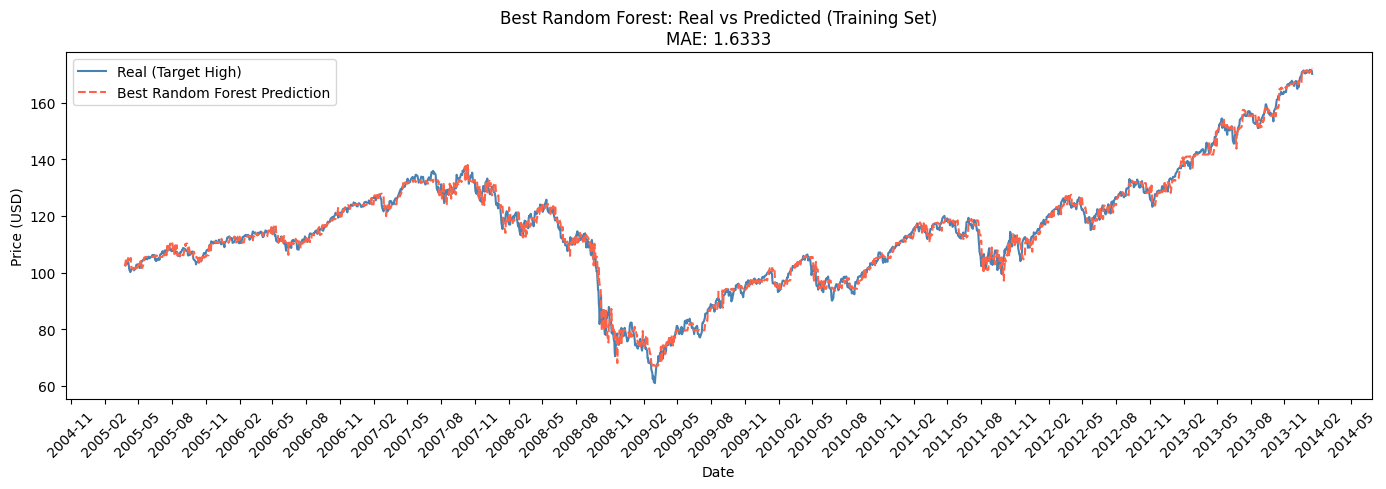

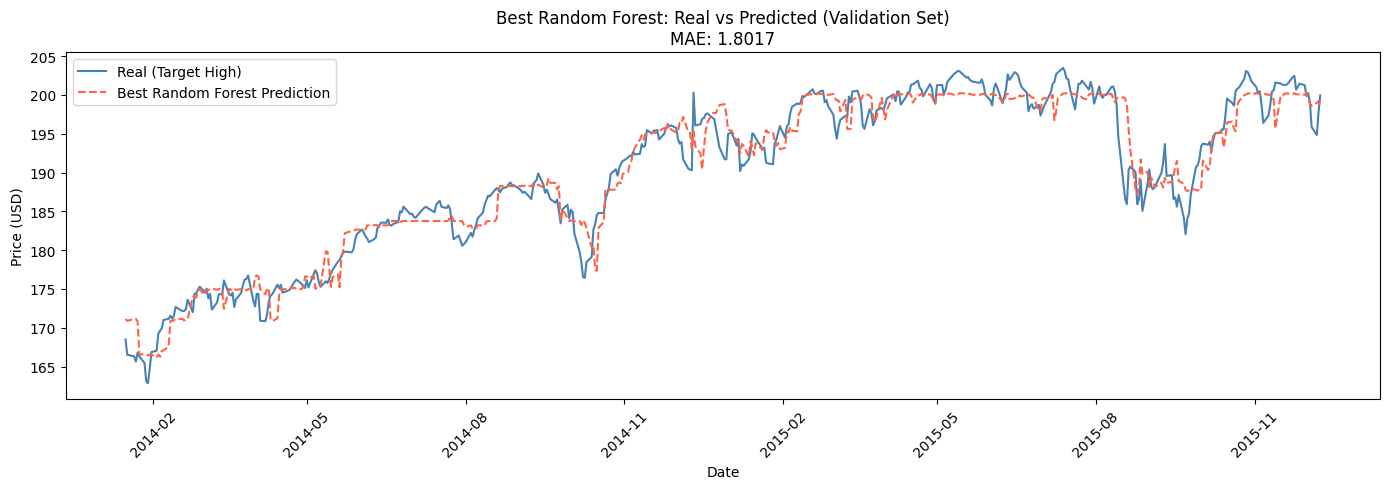

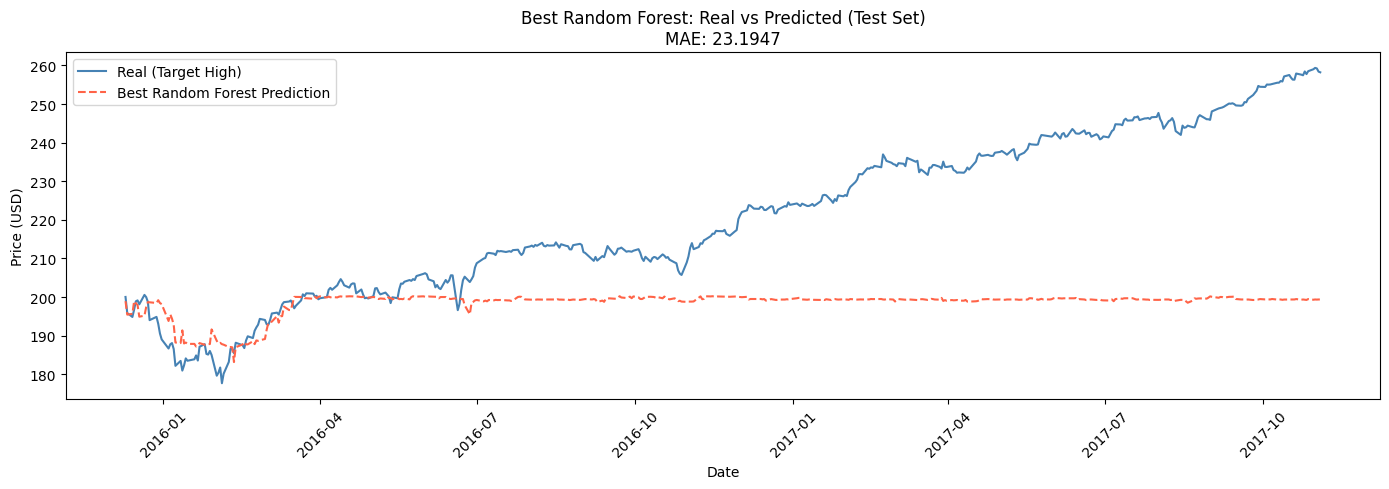

Best RF -> Train MAE: 1.6333
Best RF -> Val MAE:   1.8017
Best RF -> Test MAE:  23.1947


In [10]:
best_rf = grid_search.best_estimator_

print(f"best one: {grid_search.best_params_}\n")

mae_best_train = plot_predictions(best_rf, X_train_scaled, y_train, df, 'Training',   'Best Random Forest')
mae_best_val   = plot_predictions(best_rf, X_val_scaled,   y_val,   df, 'Validation', 'Best Random Forest')
mae_best_test  = plot_predictions(best_rf, X_test_scaled,  y_test,  df, 'Test',       'Best Random Forest')

print(f"Best RF -> Train MAE: {mae_best_train:.4f}")
print(f"Best RF -> Val MAE:   {mae_best_val:.4f}")
print(f"Best RF -> Test MAE:  {mae_best_test:.4f}")

In [11]:
#lo que pasa es el top de validation. no supera la el maximo de validation. 

### Model 2: GradientBoosting

In [12]:
# Define and train model
print("Training Gradient Boosting...")
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)

Training Gradient Boosting...


,"loss loss: {'squared_error', 'absolute_error', 'huber', 'quantile'}, default='squared_error'Loss function to be optimized. 'squared_error' refers to the squarederror for regression. 'absolute_error' refers to the absolute error ofregression and is a robust loss function. 'huber' is acombination of the two. 'quantile' allows quantile regression (use`alpha` to specify the quantile).See:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_quantile.py`for an example that demonstrates quantile regression for creatingprediction intervals with `loss='quantile'`.",'squared_error'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.",0.1
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",100
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",1.0
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are""friedman_mse"" for the mean squared error with improvement score byFriedman, ""squared_error"" for mean squared error. The default value of""friedman_mse"" is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",3
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft 

In [13]:
# Evaluation GBM
mae_gb_val = mean_absolute_error(y_val, gb_model.predict(X_val_scaled))
print(f"Gradient Boost -> Val MAE: {mae_gb_val:.4f}")

Gradient Boost -> Val MAE: 19.7642


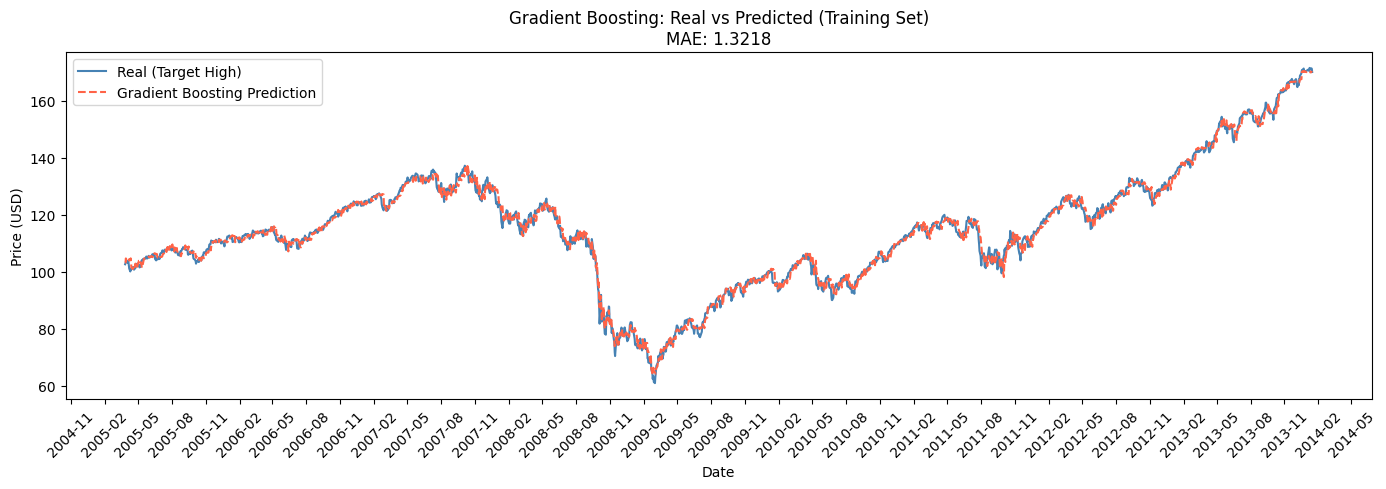

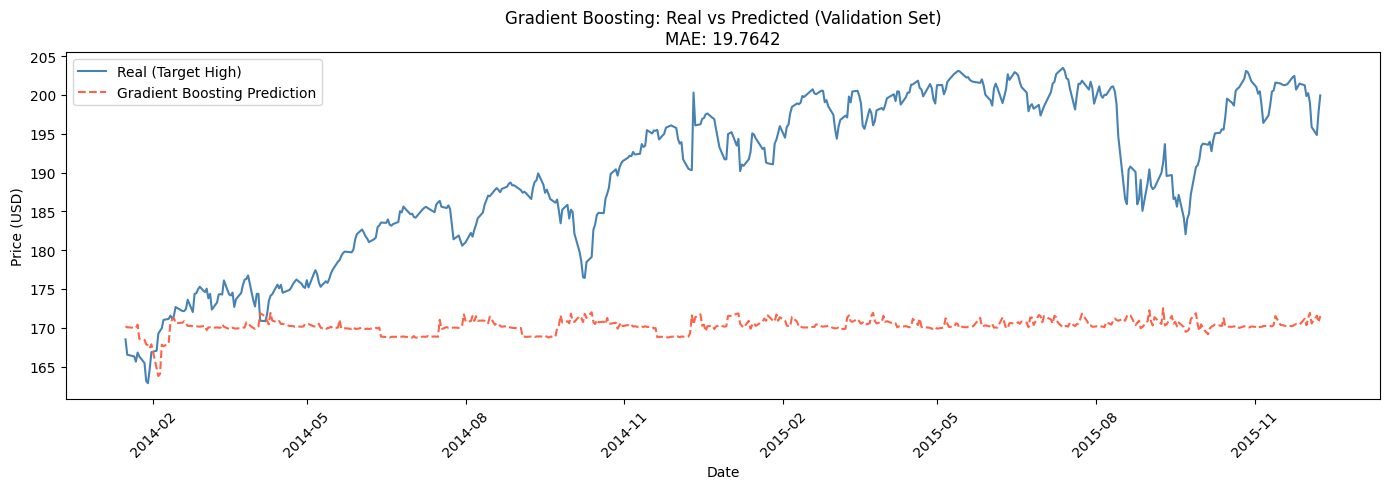

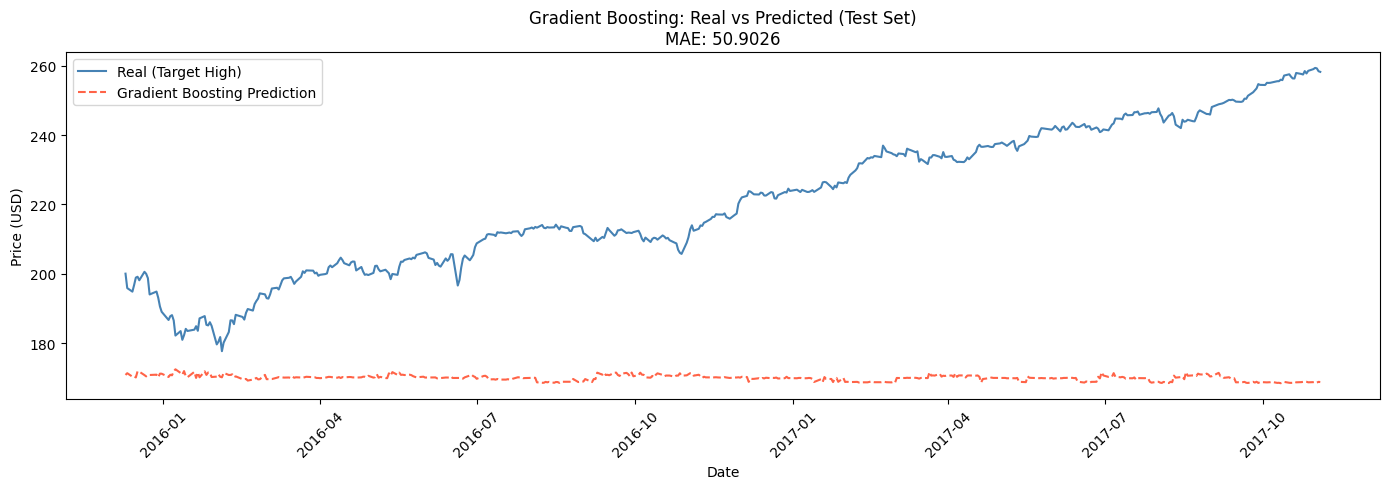

Gradient Boosting -> Train MAE: 1.3218
Gradient Boosting -> Val MAE:   19.7642
Gradient Boosting -> Test MAE:  50.9026


In [14]:
mae_gb_train = plot_predictions(gb_model, X_train_scaled, y_train, df, 'Training',   'Gradient Boosting')
mae_gb_val   = plot_predictions(gb_model, X_val_scaled,   y_val,   df, 'Validation', 'Gradient Boosting')
mae_gb_test  = plot_predictions(gb_model, X_test_scaled,  y_test,  df, 'Test',       'Gradient Boosting')

print(f"Gradient Boosting -> Train MAE: {mae_gb_train:.4f}")
print(f"Gradient Boosting -> Val MAE:   {mae_gb_val:.4f}")
print(f"Gradient Boosting -> Test MAE:  {mae_gb_test:.4f}")

In [15]:
param_grid_gb = {
    'n_estimators':     [100, 200],
    'learning_rate':    [0.01, 0.05, 0.1],
    'max_depth':        [3, 5, 7],
    'min_samples_leaf': [1, 5, 10],
}

# PredefinedSplit ensures the validation fold is always the same predefined split,
# preventing GridSearchCV from randomly shuffling the data across folds.
# This is critical for time series data, where future data must never be used to train the model.
# -1 = training samples, 0 = validation samples
split_index = [-1] * len(X_train_scaled) + [0] * len(X_val_scaled)
ps = PredefinedSplit(split_index)

X_trainval = np.concatenate([X_train_scaled, X_val_scaled])
y_trainval = np.concatenate([y_train, y_val])

grid_search_gb = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid_gb,
    cv=ps,
    scoring='neg_mean_absolute_error',
    verbose=1
)

grid_search_gb.fit(X_trainval, y_trainval)

print(f"Best params: {grid_search_gb.best_params_}")
print(f"Best Val MAE: {-grid_search_gb.best_score_:.4f}")

Fitting 1 folds for each of 54 candidates, totalling 54 fits
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 200}
Best Val MAE: 19.2517


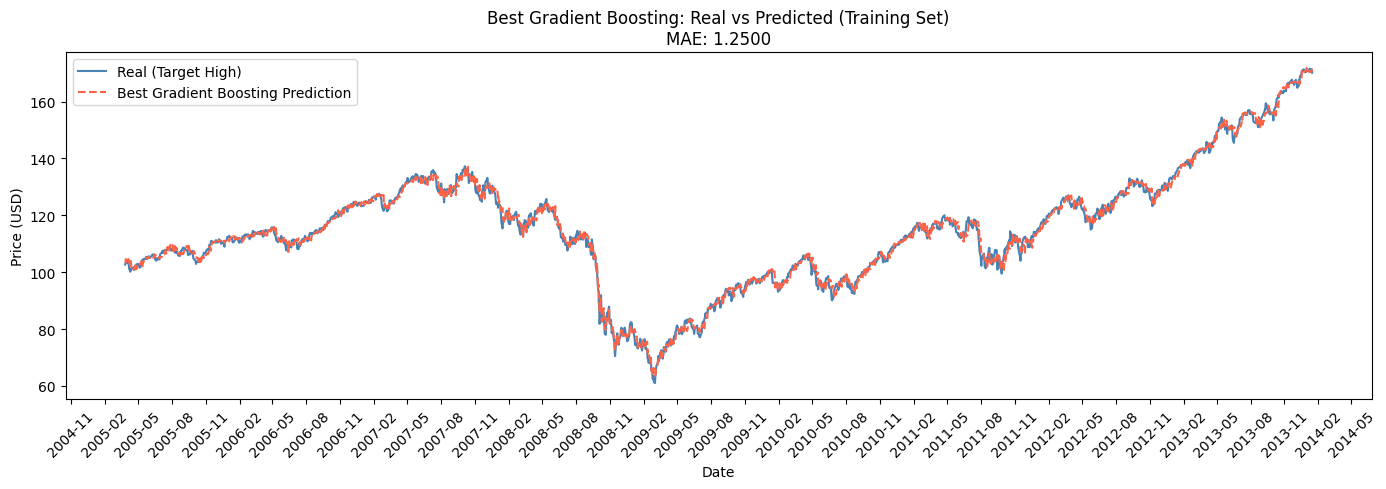

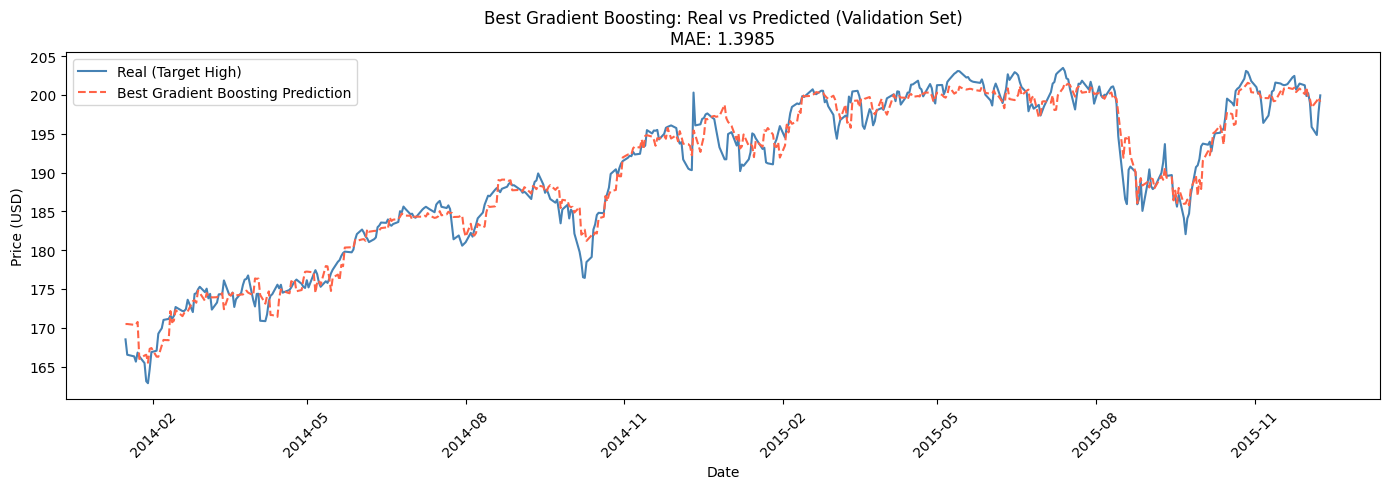

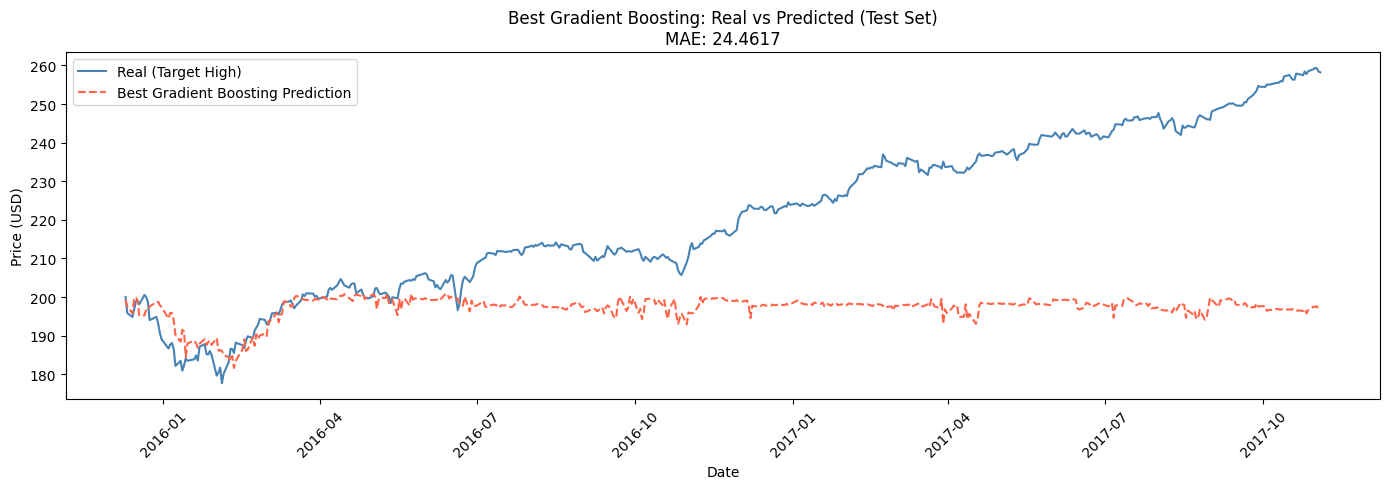

Best GBM -> Train MAE: 1.2500
Best GBM -> Val MAE:   1.3985
Best GBM -> Test MAE:  24.4617


In [16]:
best_gb = grid_search_gb.best_estimator_

mae_best_gb_train = plot_predictions(best_gb, X_train_scaled, y_train, df, 'Training',   'Best Gradient Boosting')
mae_best_gb_val   = plot_predictions(best_gb, X_val_scaled,   y_val,   df, 'Validation', 'Best Gradient Boosting')
mae_best_gb_test  = plot_predictions(best_gb, X_test_scaled,  y_test,  df, 'Test',       'Best Gradient Boosting')

print(f"Best GBM -> Train MAE: {mae_best_gb_train:.4f}")
print(f"Best GBM -> Val MAE:   {mae_best_gb_val:.4f}")
print(f"Best GBM -> Test MAE:  {mae_best_gb_test:.4f}")

Bridge variables ready: X_tr=(2217, 8), X_vl=(479, 8), X_te=(480, 8)
Number of features: 8
MLP shapes: train=(2217, 8), val=(479, 8), test=(480, 8)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,897 (222.25 KB)

 Trainable params: 55,873 (218.25 KB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 112.5265 - val_loss: 185.6150
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 88.7383 - val_loss: 127.6731
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 27.3852 - val_loss: 39.5156
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 16.6311 - val_loss: 28.9136
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13.3587 - val_loss: 15.7678
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12.5651 - val_loss: 15.8703
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 11.8568 - val_loss: 12.3410
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 11.5820 - val_loss: 9.0304
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 11.2762 - val_loss: 14.4001
Epoch 10/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 11.1249 - val_loss: 12.5123
Epoch 11/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.8092 - val_loss: 16.7282
Epoch 12/100
70/70 ━━━━━━━━━━━━━━━━━━━

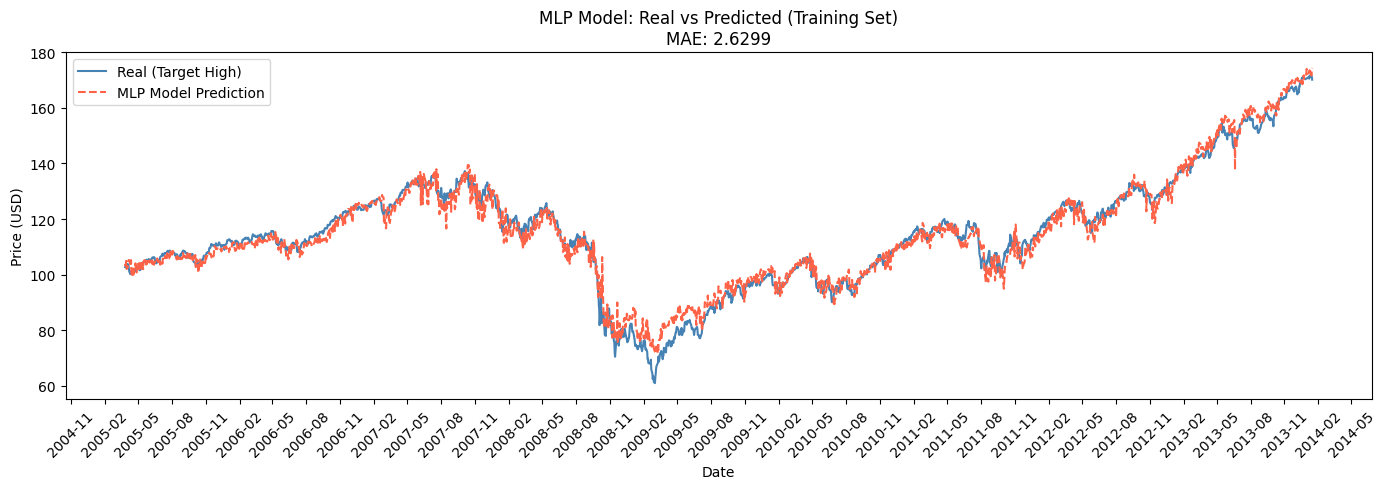

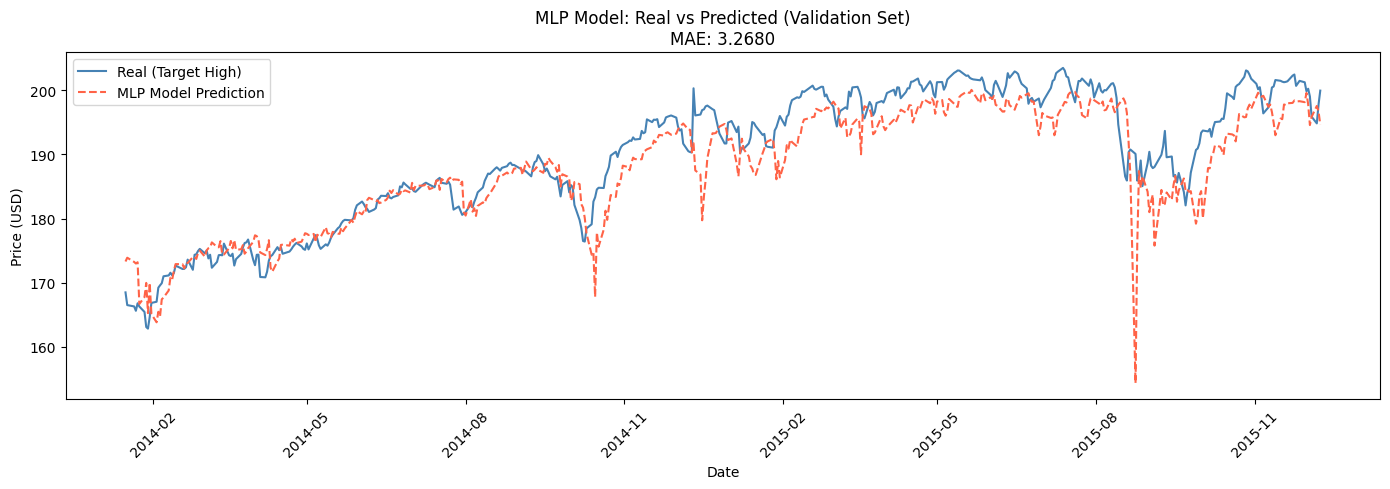

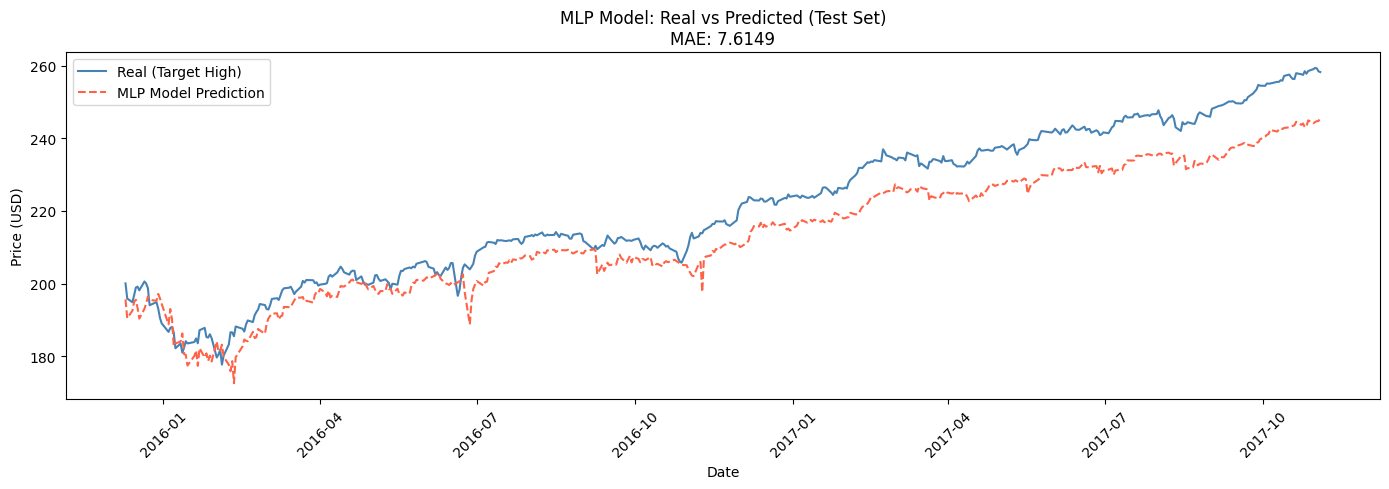

7.614886128489176

In [7]:
tf.random.set_seed(42)
np.random.seed(42)

n_features = X_train_scaled.shape[1]
print(f"Bridge variables ready: X_tr={X_train_scaled.shape}, X_vl={X_val_scaled.shape}, X_te={X_test_scaled.shape}")
print(f"Number of features: {n_features}")
print(f"MLP shapes: train={X_train_scaled.shape}, val={X_val_scaled.shape}, test={X_test_scaled.shape}")

# MLP Architecture
model_A = Sequential([
    Input(shape=(n_features,)),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),

    Dense(1)
])

model_A.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='mae'
)

model_A.summary()

# Train with EarlyStopping
history_A = model_A.fit(
    X_train_scaled, y_train.values,
    validation_data=(X_val_scaled, y_val.values),
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )],
    verbose=1
)

# Evaluate
y_pred_train_A = model_A.predict(X_train_scaled, verbose=0).flatten()
y_pred_val_A   = model_A.predict(X_val_scaled, verbose=0).flatten()
y_pred_test_A  = model_A.predict(X_test_scaled, verbose=0).flatten()

mae_train_A = mean_absolute_error(y_train.values, y_pred_train_A)
mae_val_A   = mean_absolute_error(y_val.values, y_pred_val_A)
mae_test_A  = mean_absolute_error(y_test.values, y_pred_test_A)

print(f"\n--- MLP Model ---")
print(f"Train MAE: {mae_train_A:.4f}")
print(f"Val   MAE: {mae_val_A:.4f}")
print(f"Test  MAE: {mae_test_A:.4f}")

# Plots (reuse your function)
plot_predictions_LPM(y_train.values, y_pred_train_A, X_train.index, df, 'Training', 'MLP Model')
plot_predictions_LPM(y_val.values, y_pred_val_A,   X_val.index,   df, 'Validation', 'MLP Model')
plot_predictions_LPM(y_test.values, y_pred_test_A,  X_test.index,  df, 'Test', 'MLP Model')

## Online Learning

In [ ]:
# Create Pipeline: Feature Extraction -> Model
# We use HoeffdingAdaptiveTreeRegressor
river_model = compose.Pipeline(
    OnlineSPYFeatures(),   # Custom transformer to extract features from the raw data stream
    preprocessing.StandardScaler(),  # Scales the data (standarization) to avoid inestability
    tree.HoeffdingAdaptiveTreeRegressor(
        grace_period=50,       # How often to check for splits
        model_selector_decay=0.9
    )
)

# Metric for Validation
metric_val  = metrics.MAE()
metric_test = metrics.MAE()

In [ ]:
# We iterate through the entire dataset sequentially
print("Processing stream row by row...")
records_val  = []
records_test = []
for i, (index, row) in enumerate(df.iterrows()):
    
    # Prepare input (x) and target (y)
    x = row[['Open', 'High', 'Low', 'Close', 'Volume']].to_dict()
    y = row['Target_High']
    
    # 1. PREDICT (Test-then-Train approach)
    # We make a prediction before the model learns from this specific example
    y_pred = river_model.predict_one(x)   # predict_one takes the x, transforms it with OnlineSPYFeatures and StandardScaler, and predicts with the model
    
    # 2. UPDATE METRICS
    # We only update the metric if we are currently in the Validation segment (would be equivalent for test)
    if index in X_val.index:
        metric_val.update(y, y_pred)
        records_val.append({'date': row['Date'], 'y_real': y, 'y_pred': y_pred})

    if index in X_test.index:
        metric_test.update(y, y_pred)
        records_test.append({'date': row['Date'], 'y_real': y, 'y_pred': y_pred})
    # 3. LEARN
    # The model updates its internal state with the new truth
    river_model.learn_one(x, y)

Processing stream row by row...


In [ ]:
print(f"Online HoeffdingAdaptiveTreeRegressor -> Val MAE: {metric_val.get():.4f}")
print(f"Online HoeffdingAdaptiveTreeRegressor -> Val MAE: {metric_test.get():.4f}")

Online HoeffdingAdaptiveTreeRegressor -> Val MAE: 3.5726
Online HoeffdingAdaptiveTreeRegressor -> Val MAE: 2.0622


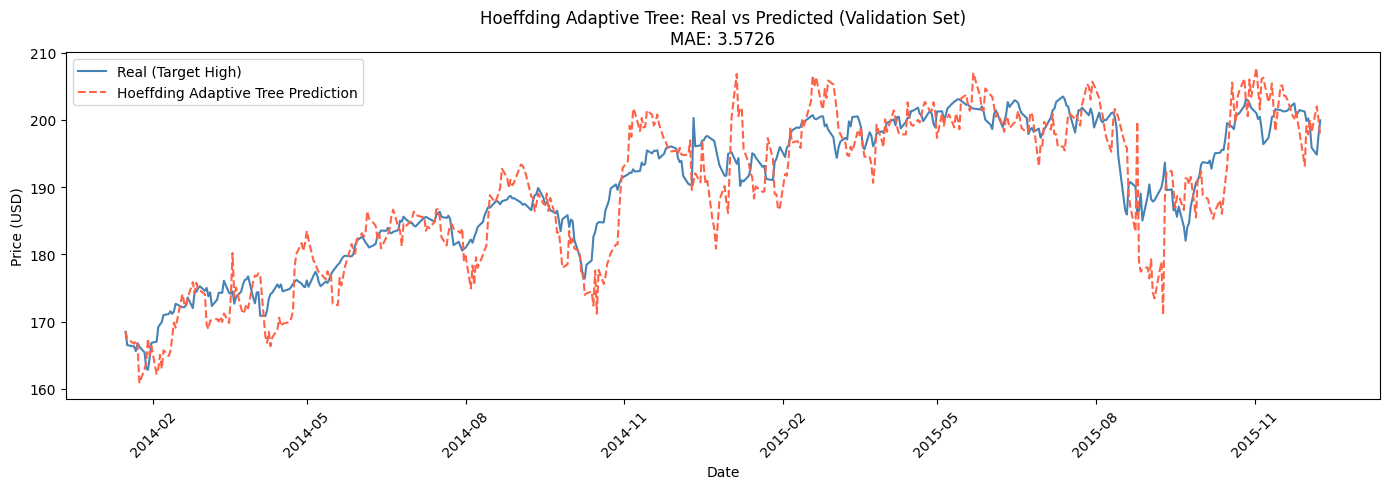

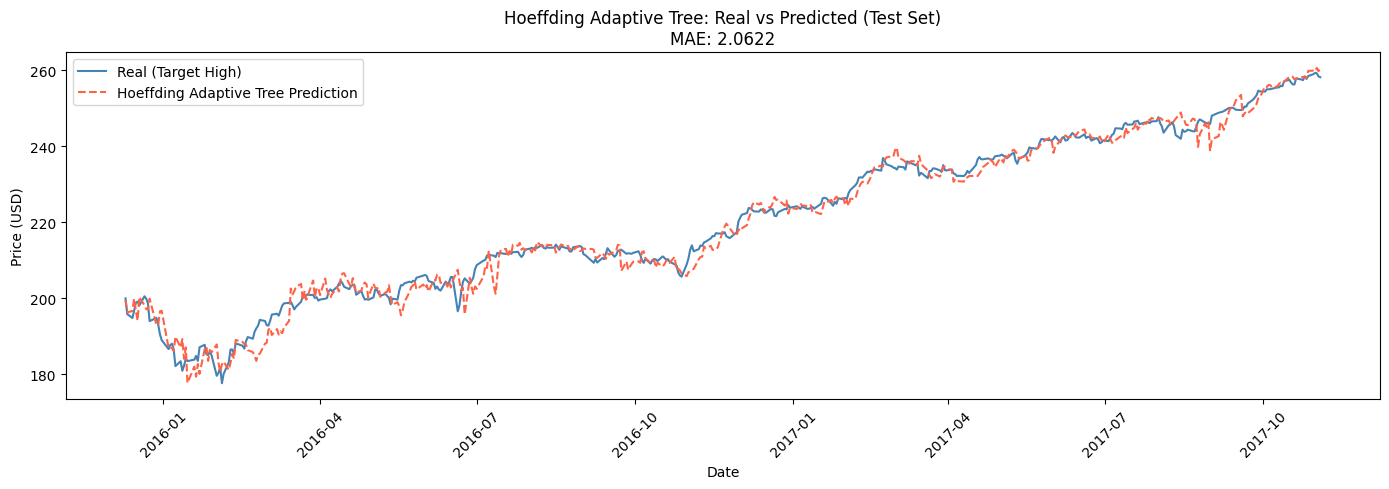

In [ ]:
def plot_predictions_online(records, set_name, model_name='Online Model'):
    df_plot = pd.DataFrame(records)
    df_plot['date'] = pd.to_datetime(df_plot['date'])
    mae = mean_absolute_error(df_plot['y_real'], df_plot['y_pred'])

    fig, ax = plt.subplots(figsize=(14, 5))
    ax.plot(df_plot['date'], df_plot['y_real'], label='Real (Target High)', color='steelblue', linewidth=1.5)
    ax.plot(df_plot['date'], df_plot['y_pred'], label=f'{model_name} Prediction', color='tomato', linewidth=1.5, linestyle='--')

    ax.set_title(f'{model_name}: Real vs Predicted ({set_name} Set)\nMAE: {mae:.4f}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price (USD)')
    ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return mae


mae_online_val  = plot_predictions_online(records_val,  'Validation', 'Hoeffding Adaptive Tree')
mae_online_test = plot_predictions_online(records_test, 'Test',       'Hoeffding Adaptive Tree')
